**Лабораторная работа №1**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import struct
from array import array
import os
import random

In [2]:
def relu(x):
    return np.maximum(0, x)

#Производная ReLU
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):

    x_shifted = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x_shifted)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#Кросс-энтропия для one-hot представления меток.
def cross_entropy(y_true, y_pred):
    # 1e-8 для избежания log(0)
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))
#Доля правильных ответов.
def accuracy(y_true, y_pred):
    true_labels = np.argmax(y_true, axis=1)
    pred_labels = np.argmax(y_pred, axis=1)
    return np.mean(true_labels == pred_labels)

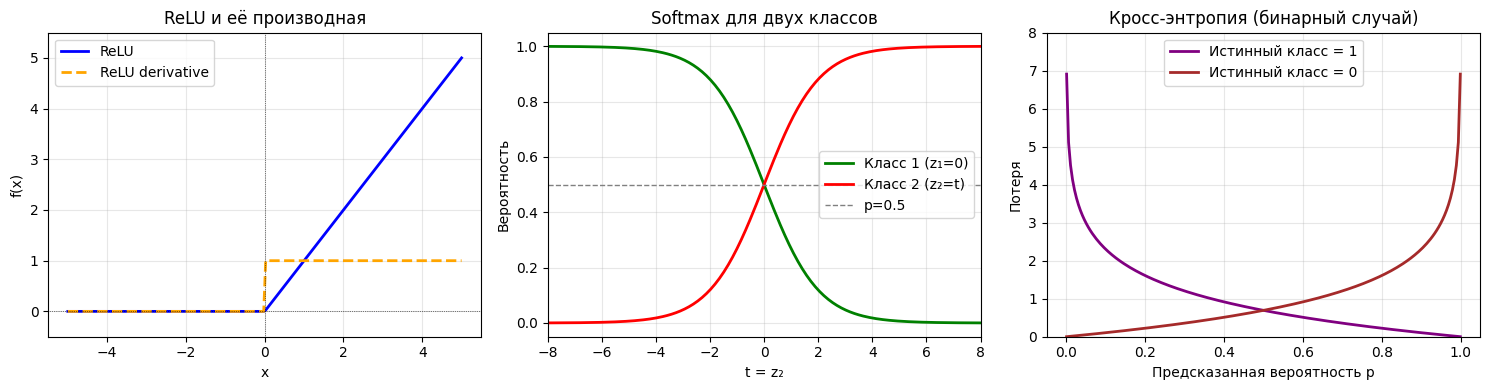

In [3]:
# визуализация функций
# relu
x = np.linspace(-5, 5, 200)
y_relu = relu(x)
y_relu_deriv = relu_derivative(x)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(x, y_relu, label='ReLU', linewidth=2, color='blue')
plt.plot(x, y_relu_deriv, label='ReLU derivative', linewidth=2, linestyle='--', color='orange')
plt.axhline(0, color='black', linewidth=0.5, linestyle=':')
plt.axvline(0, color='black', linewidth=0.5, linestyle=':')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.title('ReLU и её производная', fontsize=12)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-0.5, 5.5)

# Softmax для двух классов
# Рассмотрим случай двух классов с логитами z = [0, t]
t = np.linspace(-8, 8, 200)
softmax_class1 = 1 / (1 + np.exp(t))      # softmax первого класса
softmax_class2 = 1 - softmax_class1       # softmax второго класса

plt.subplot(1, 3, 2)
plt.plot(t, softmax_class1, label='Класс 1 (z₁=0)', linewidth=2, color='green')
plt.plot(t, softmax_class2, label='Класс 2 (z₂=t)', linewidth=2, color='red')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='p=0.5')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.title('Softmax для двух классов', fontsize=12)
plt.xlabel('t = z₂')
plt.ylabel('Вероятность')
plt.xlim(-8, 8)

# кросс-энтропия для бинарной классификации истинная метка y=1 и y=0
p = np.linspace(0.001, 0.999, 200)
ce_y1 = -np.log(p)           # для истинного класса 1
ce_y0 = -np.log(1 - p)       # для истинного класса 0

plt.subplot(1, 3, 3)
plt.plot(p, ce_y1, label='Истинный класс = 1', linewidth=2, color='purple')
plt.plot(p, ce_y0, label='Истинный класс = 0', linewidth=2, color='brown')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.title('Кросс-энтропия (бинарный случай)', fontsize=12)
plt.xlabel('Предсказанная вероятность p')
plt.ylabel('Потеря')
plt.ylim(0, 8)

plt.tight_layout()
plt.show()

In [4]:
class TwoLayerNeuralNetwork:

    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden_dim))

        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros((1, output_dim))

    # Прямой проход
    def forward(self, X):
        # Скрытый слой z1 = X * W1 + b1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)

        # Выходной слой z2 = a1 * W2 + b2
        self.z2 = np.dot(self.a1, self.W2) + self.b2

        self.probs = softmax(self.z2)
        return self.probs
    # Обратное распространение ошибки и обновление весов
    def backward(self, X, y_onehot, lr):
        batch_size = X.shape[0]

        # Градиент на выходном слое (softmax + cross-entropy дают просто p - y)
        dL_dz2 = self.probs - y_onehot

        # Усредняем
        dL_dz2 /= batch_size

        # Градиенты для выходного слоя
        dL_dW2 = np.dot(self.a1.T, dL_dz2)
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)

        # Градиент, проходящий через скрытый слой
        dL_da1 = np.dot(dL_dz2, self.W2.T)

        dL_dz1 = dL_da1 * relu_derivative(self.z1)

        # Градиенты для скрытого слоя
        dL_dW1 = np.dot(X.T, dL_dz1)
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

        # Обновление параметров
        self.W1 -= lr * dL_dW1
        self.b1 -= lr * dL_db1
        self.W2 -= lr * dL_dW2
        self.b2 -= lr * dL_db2

    # Обучение сети на тренировочных данных
    def fit(self, X_train, y_train, epochs, lr, batch_size, verbose=True):
        n_samples = X_train.shape[0]
        history = {'loss': [], 'accuracy': []}
        total_start = time.time()

        for epoch in range(1, epochs + 1):
            epoch_start = time.time()

            # Перемещиваем данные в начале каждой эпохи
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            # Итерация по батчам
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Прямой проход
                _ = self.forward(X_batch)
                # Обратный проход и обновление
                self.backward(X_batch, y_batch, lr)

            # Оценка после эпохи на всей обучающей выборке
            train_pred = self.forward(X_train)
            loss = cross_entropy(y_train, train_pred)
            acc = accuracy(y_train, train_pred)
            history['loss'].append(loss)
            history['accuracy'].append(acc)

            epoch_time = time.time() - epoch_start
            if verbose:
                print(f"Эпоха {epoch}/{epochs} | Потери: {loss:.4f} | Точность: {acc:.4f} | Время: {epoch_time:.2f}с")

        total_time = time.time() - total_start
        print(f"Обучение завершено за {total_time:.2f} секунд.")
        return history
    #Оценка на тестовых данных: точность и потери
    def evaluate(self, X_test, y_test):
        test_pred = self.forward(X_test)
        test_loss = cross_entropy(y_test, test_pred)
        test_acc = accuracy(y_test, test_pred)
        print(f"Тестовая точность: {test_acc:.4f} | Тестовые потери: {test_loss:.4f}")
        return test_acc, test_loss

In [5]:
#Загрузчик данных MNIST
class MNISTDataLoader:
    def __init__(self, train_img_path, train_lbl_path, test_img_path, test_lbl_path):
        self.train_img_path = train_img_path
        self.train_lbl_path = train_lbl_path
        self.test_img_path = test_img_path
        self.test_lbl_path = test_lbl_path

    def _read_images_labels(self, img_path, lbl_path):
        # чтение меток
        with open(lbl_path, 'rb') as f:
            magic, n_items = struct.unpack(">II", f.read(8))
            if magic != 2049:
                raise ValueError(f"Неверный magic number в файле меток: {magic}")
            labels = array("B", f.read())

        # чтение изображений
        with open(img_path, 'rb') as f:
            magic, n_images, rows, cols = struct.unpack(">IIII", f.read(16))
            if magic != 2051:
                raise ValueError(f"Неверный magic number в файле изображений: {magic}")
            img_data = array("B", f.read())

        # преобразование в список списков
        images = []
        for i in range(n_images):
            start = i * rows * cols
            end = (i + 1) * rows * cols
            img_flat = list(img_data[start:end])
            images.append(img_flat)
        return images, labels

    def load(self):
        x_train, y_train = self._read_images_labels(self.train_img_path, self.train_lbl_path)
        x_test, y_test = self._read_images_labels(self.test_img_path, self.test_lbl_path)
        return (x_train, y_train), (x_test, y_test)

In [6]:
import kagglehub

path = kagglehub.dataset_download("hojjatk/mnist-dataset")
print("Путь к файлам датасета:", path)

def find_file(directory, pattern):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if pattern in file:
                return os.path.join(root, file)
    return None

train_img = find_file(path, 'train-images')
train_lbl = find_file(path, 'train-labels')
test_img  = find_file(path, 't10k-images')
test_lbl  = find_file(path, 't10k-labels')

if None in (train_img, train_lbl, test_img, test_lbl):
    raise FileNotFoundError("Не удалось найти файлы")

print("Найдены файлы:")
print(f"train_img: {train_img}")
print(f"train_lbl: {train_lbl}")
print(f"test_img:  {test_img}")
print(f"test_lbl:  {test_lbl}")

# загружаем данные
loader = MNISTDataLoader(train_img, train_lbl, test_img, test_lbl)
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = loader.load()

#преобразуем в numpy массивы
x_train_raw = np.array(x_train_raw)
y_train_raw = np.array(y_train_raw)
x_test_raw = np.array(x_test_raw)
y_test_raw = np.array(y_test_raw)

print("Размерности после загрузки:")
print(f"x_train: {x_train_raw.shape}, y_train: {y_train_raw.shape}")
print(f"x_test : {x_test_raw.shape}, y_test : {y_test_raw.shape}")

Using Colab cache for faster access to the 'mnist-dataset' dataset.
Путь к файлам датасета: /kaggle/input/mnist-dataset
Найдены файлы:
train_img: /kaggle/input/mnist-dataset/train-images.idx3-ubyte
train_lbl: /kaggle/input/mnist-dataset/train-labels.idx1-ubyte
test_img:  /kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
test_lbl:  /kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
Размерности после загрузки:
x_train: (60000, 784), y_train: (60000,)
x_test : (10000, 784), y_test : (10000,)


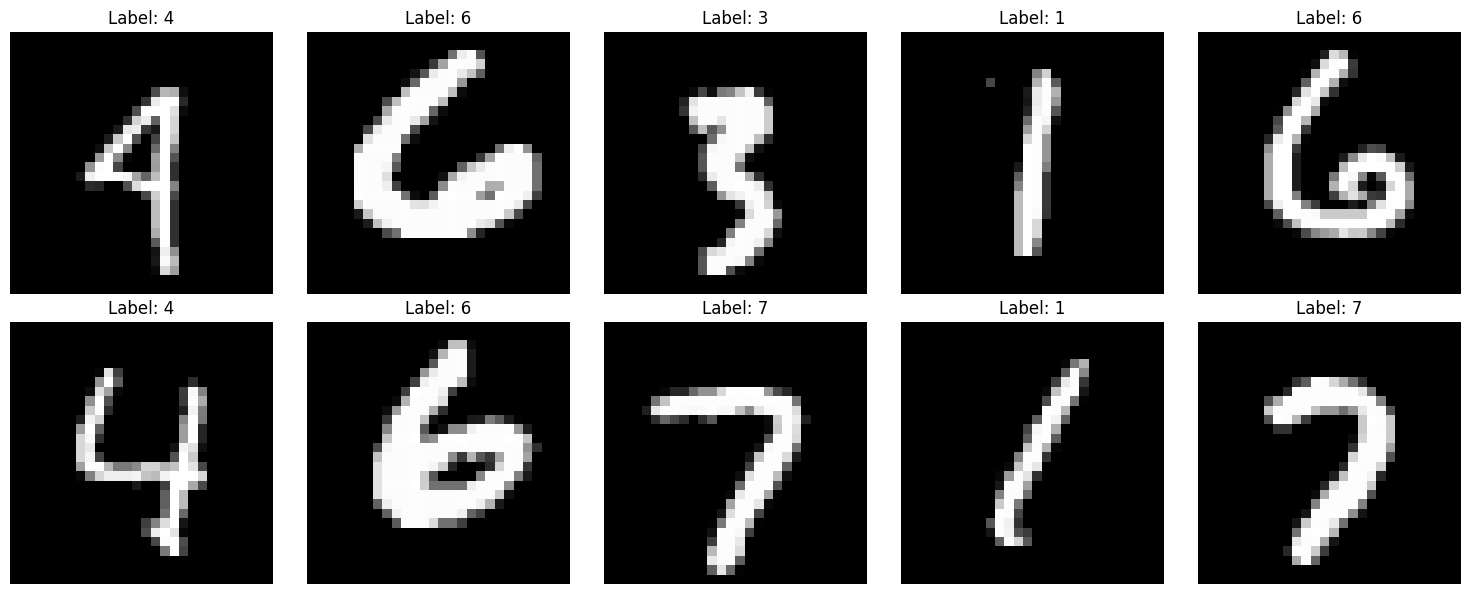

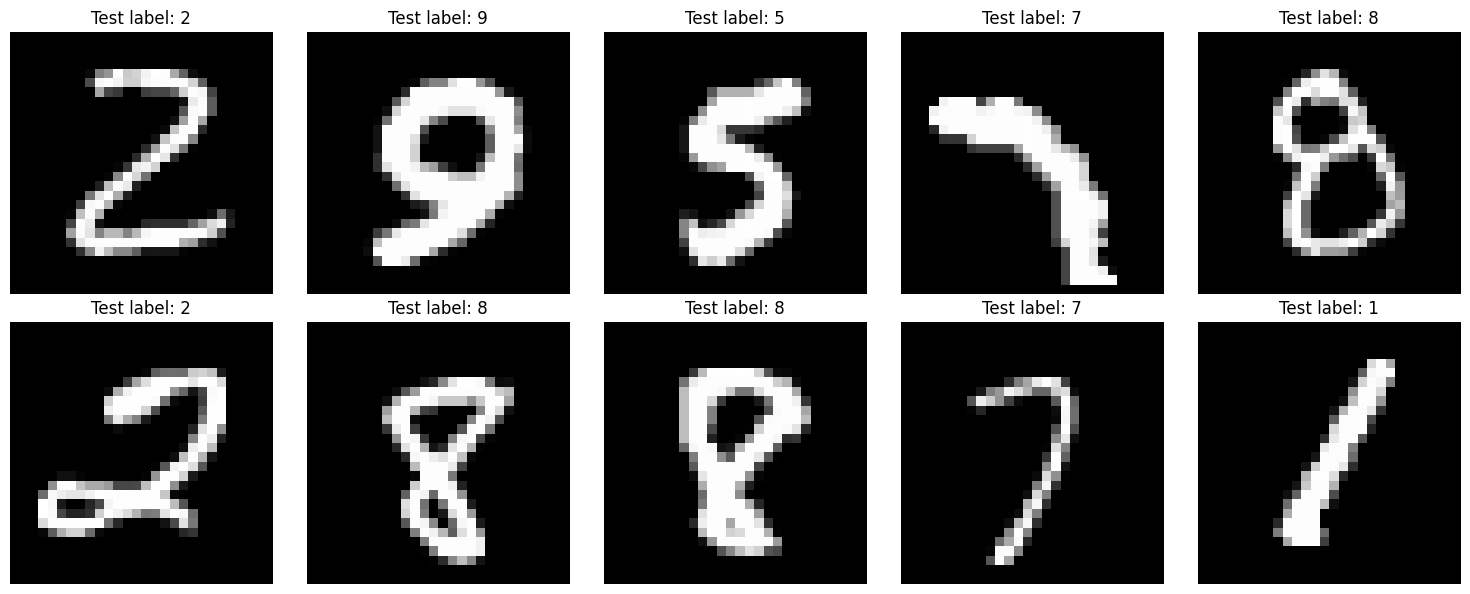

In [7]:
def show_image_grid(images, titles, rows=2, cols=5, figsize=(15,6)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# cлучайные обучающие изображения
sample_indices = random.sample(range(len(x_train_raw)), 10)
sample_images = [x_train_raw[i].reshape(28,28) for i in sample_indices]
sample_titles = [f"Label: {y_train_raw[i]}" for i in sample_indices]
show_image_grid(sample_images, sample_titles, rows=2, cols=5)

#cлучайные тестовые изображения
sample_indices_test = random.sample(range(len(x_test_raw)), 10)
test_images = [x_test_raw[i].reshape(28,28) for i in sample_indices_test]
test_titles = [f"Test label: {y_test_raw[i]}" for i in sample_indices_test]
show_image_grid(test_images, test_titles, rows=2, cols=5)

In [8]:
input_size = 28 * 28
hidden_size = 300
output_size = 10
learning_rate = 0.1
epochs = 20
batch_size = 64

In [9]:
x_train = x_train_raw.reshape(-1, input_size) / 255.0
x_test = x_test_raw.reshape(-1, input_size) / 255.0

# One hot кодирование меток
y_train = np.eye(output_size)[y_train_raw]
y_test = np.eye(output_size)[y_test_raw]

print("Данные подготовлены.")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test : {x_test.shape}, y_test : {y_test.shape}")

Данные подготовлены.
x_train: (60000, 784), y_train: (60000, 10)
x_test : (10000, 784), y_test : (10000, 10)


In [10]:
# Создание и обучение модели
model = TwoLayerNeuralNetwork(input_size, hidden_size, output_size)
history = model.fit(x_train, y_train, epochs=epochs, lr=learning_rate,
                    batch_size=batch_size, verbose=True)

Эпоха 1/20 | Потери: 0.2280 | Точность: 0.9336 | Время: 8.78с
Эпоха 2/20 | Потери: 0.1522 | Точность: 0.9571 | Время: 6.12с
Эпоха 3/20 | Потери: 0.1222 | Точность: 0.9661 | Время: 9.17с
Эпоха 4/20 | Потери: 0.1014 | Точность: 0.9718 | Время: 5.98с
Эпоха 5/20 | Потери: 0.0786 | Точность: 0.9789 | Время: 8.40с
Эпоха 6/20 | Потери: 0.0719 | Точность: 0.9800 | Время: 5.74с
Эпоха 7/20 | Потери: 0.0630 | Точность: 0.9832 | Время: 8.45с
Эпоха 8/20 | Потери: 0.0500 | Точность: 0.9868 | Время: 5.96с
Эпоха 9/20 | Потери: 0.0496 | Точность: 0.9864 | Время: 8.28с
Эпоха 10/20 | Потери: 0.0407 | Точность: 0.9898 | Время: 6.35с
Эпоха 11/20 | Потери: 0.0374 | Точность: 0.9905 | Время: 7.82с
Эпоха 12/20 | Потери: 0.0334 | Точность: 0.9922 | Время: 6.40с
Эпоха 13/20 | Потери: 0.0300 | Точность: 0.9934 | Время: 8.28с
Эпоха 14/20 | Потери: 0.0262 | Точность: 0.9947 | Время: 7.01с
Эпоха 15/20 | Потери: 0.0240 | Точность: 0.9956 | Время: 6.82с
Эпоха 16/20 | Потери: 0.0246 | Точность: 0.9951 | Время: 6.52с
Э

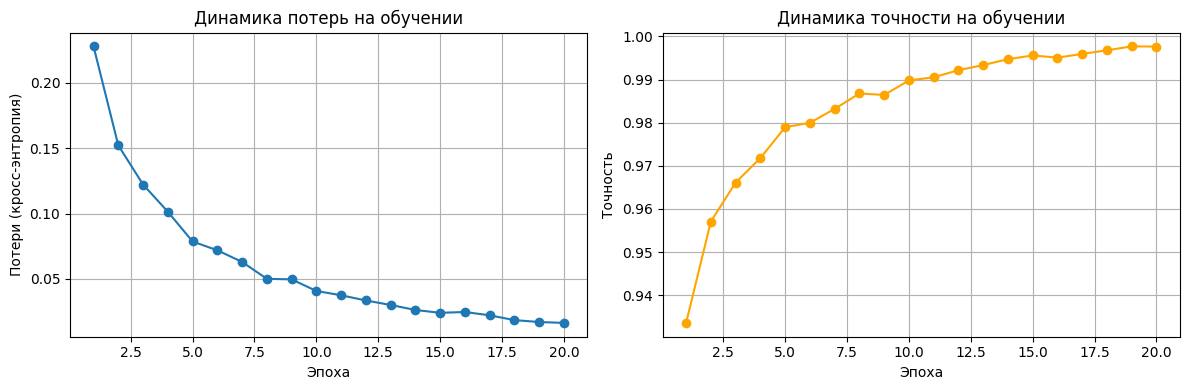

In [11]:
# Визуализация
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), history['loss'], marker='o')
plt.xlabel('Эпоха')
plt.ylabel('Потери (кросс-энтропия)')
plt.title('Динамика потерь на обучении')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), history['accuracy'], marker='o', color='orange')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Динамика точности на обучении')
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Оценка на тестовых данных
test_acc, test_loss = model.evaluate(x_test, y_test)
print(f"\nИтоговая точность на тесте: {test_acc*100:.2f}%")

Тестовая точность: 0.9808 | Тестовые потери: 0.0646

Итоговая точность на тесте: 98.08%


Всего правильных: 9808


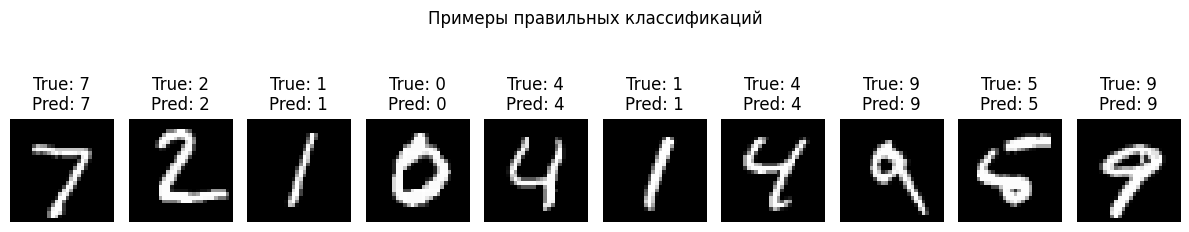

Всего ошибок: 192


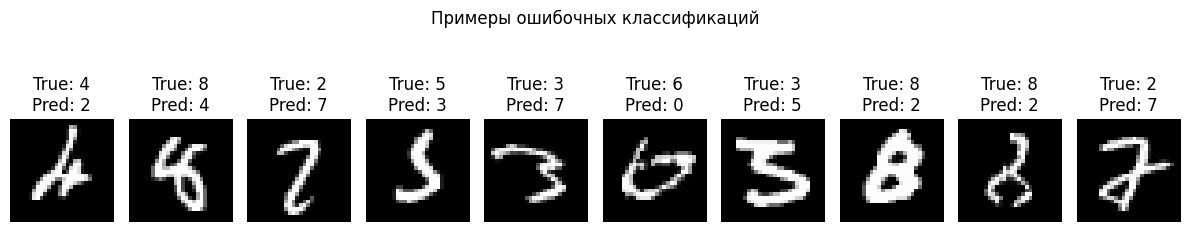

In [13]:
probs_test = model.forward(x_test)
pred_test = np.argmax(probs_test, axis=1)
true_test = np.argmax(y_test, axis=1)
correct = np.where(pred_test == true_test)[0]
mistakes = np.where(pred_test != true_test)[0]
if len(correct) > 0:
    print(f"Всего правильных: {len(correct)}")
    plt.figure(figsize=(12,3))
    for i, idx in enumerate(correct[:10]):
        plt.subplot(1,10,i+1)
        plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
        plt.title(f"True: {true_test[idx]}\nPred: {pred_test[idx]}")
        plt.axis('off')
    plt.suptitle('Примеры правильных классификаций')
    plt.tight_layout()
    plt.show()

if len(mistakes) > 0:
    print(f"Всего ошибок: {len(mistakes)}")
    plt.figure(figsize=(12,3))
    for i, idx in enumerate(mistakes[:10]):
        plt.subplot(1,10,i+1)
        plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
        plt.title(f"True: {true_test[idx]}\nPred: {pred_test[idx]}")
        plt.axis('off')
    plt.suptitle('Примеры ошибочных классификаций')
    plt.tight_layout()
    plt.show()